In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models

import cv2
from PIL import Image
from torchvision import transforms

In [2]:
!pip install nopdb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for nopdb from https://files.pythonhosted.org/packages/e9/ea/b1d9ea3e7f34580d2128f7785926647338e80f2d20572024c13f3fa885dd/nopdb-0.2.0-py3-none-any.whl.metadata


In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------

from functools import partial

import torch
import torch.nn as nn

import timm.models.vision_transformer


class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, mask_ratio = 0.0, is_lora=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        self.global_pool = global_pool
        self.mask_ratio = mask_ratio
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm
        self.is_lora = is_lora

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        outcome = self.forward_pre_head(x)

        return outcome

    def forward_pre_head(self, x):
        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]
        return outcome

    def forward_linearprob_offline(self, x):
        x = self.forward_pre_head(x)
        x = self.head(x)
        return x

    def forward_features_kd(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        result = []
        for blk in self.blocks:
            x = blk(x)
            result.append(x)

        if not self.is_lora:
            result.append(self.norm(x))

        return result


    def forward_features_disk(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        return x

    def forward_features_lora(self, x, mask_already_applied=False):
        B = x.shape[0]

        if mask_already_applied is False and self.mask_ratio != 0:
            x = self.patch_embed(x)
            x = x + self.pos_embed[:, 1:, :]
            x, mask, ids_restore, ids_to_keep = self.random_masking(x, mask_ratio=self.mask_ratio)
        elif mask_already_applied is False and self.mask_ratio == 0:
            x = self.patch_embed(x)

        x_copy = x.clone()
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        if self.mask_ratio == 0 and mask_already_applied is False:
            x = x + self.pos_embed
        x = self.pos_drop(x)

        intermediary_results = []
        for blk in self.blocks:
            x = blk(x)
            intermediary_results.append(x)

        x = self.norm(x)
        return x, x_copy, intermediary_results


    def forward_features_transfer(self, x):
        x = self.patch_embed(x)

        x = x + self.pos_embed[:, 1:]

        for blk in self.blocks:
            x = blk(x)

        return x


    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore, ids_keep

# Sheng Wang at Feb 22 2023

import math

import timm
import torch
import torch.nn as nn
from safetensors import safe_open
from safetensors.torch import save_file
from torch import Tensor
from torch.nn.parameter import Parameter



class _LoRA_qkv_timm(nn.Module):
    def __init__(
            self,
            qkv: nn.Module,
            linear_a_q: nn.Module,
            linear_b_q: nn.Module,
            linear_a_v: nn.Module,
            linear_b_v: nn.Module,
    ):
        super().__init__()
        self.qkv = qkv
        self.linear_a_q = linear_a_q
        self.linear_b_q = linear_b_q
        self.linear_a_v = linear_a_v
        self.linear_b_v = linear_b_v
        self.dim = qkv.in_features
        self.w_identity = torch.eye(qkv.in_features)

    def forward(self, x):
        qkv = self.qkv(x)  # B,N,3*org_C
        new_q = self.linear_b_q(self.linear_a_q(x))
        new_v = self.linear_b_v(self.linear_a_v(x))
        qkv[:, :, : self.dim] += new_q
        qkv[:, :, -self.dim:] += new_v
        return qkv


class _LoRA_fc(nn.Module):
    def __init__(
            self,
            old_fc: nn.Module,
            linear_a_fc: nn.Module,
            linear_b_fc: nn.Module,
    ):
        super().__init__()
        self.old_fc = old_fc
        self.linear_a_fc = linear_a_fc
        self.linear_b_fc = linear_b_fc

    def forward(self, x):
        fc = self.old_fc(x)
        new_fc = self.linear_b_fc(self.linear_a_fc(x))

        return fc + new_fc

class _LoRA_qkv(nn.Module):
    def __init__(
            self,
            qkv: nn.Module,
            linear_a_q: nn.Module,
            linear_b_q: nn.Module,
            linear_a_v: nn.Module,
            linear_b_v: nn.Module,
            linear_a_k: nn.Module,
            linear_b_k: nn.Module
    ):
        super().__init__()
        self.qkv = qkv

        self.linear_a_q = linear_a_q
        self.linear_b_q = linear_b_q

        self.linear_a_v = linear_a_v
        self.linear_b_v = linear_b_v

        self.linear_a_k = linear_a_k
        self.linear_b_k = linear_b_k

        self.dim = qkv.in_features
        self.w_identity = torch.eye(qkv.in_features)

    def forward(self, x):
        qkv = self.qkv(x)  # B,N,3*org_C
        new_q = self.linear_b_q(self.linear_a_q(x))
        new_v = self.linear_b_v(self.linear_a_v(x))
        new_k = self.linear_b_k(self.linear_a_k(x))
        qkv[:, :, :self.dim] += new_q
        qkv[:, :, self.dim:-self.dim] += new_k
        qkv[:, :, -self.dim:] += new_v
        return qkv


class LoRA_ViT_timm(nn.Module):
    def __init__(self, vit_model: VisionTransformer, r: int, reduction_factor=2):
        super(LoRA_ViT_timm, self).__init__()

        assert r > 0
        self.lora_layer = list(range(0, len(vit_model.blocks), reduction_factor))

        self.w_As = []  # These are linear layers
        self.w_Bs = []

        # lets freeze first
        for param in vit_model.parameters():
            param.requires_grad = False

        # Here, we do the surgery
        for t_layer_i, blk in enumerate(vit_model.blocks):
            # If we only want few lora layer instead of all
            # TODO: why not removing the unused layers in the beginning?
            if t_layer_i not in self.lora_layer:
                continue

            ### qkv
            w_qkv_linear = blk.attn.qkv
            self.dim = w_qkv_linear.in_features
            w_a_linear_q = nn.Linear(self.dim, r, bias=False)
            w_b_linear_q = nn.Linear(r, self.dim, bias=False)
            w_a_linear_v = nn.Linear(self.dim, r, bias=False)
            w_b_linear_v = nn.Linear(r, self.dim, bias=False)
            w_a_linear_k = nn.Linear(self.dim, r, bias=False)
            w_b_linear_k = nn.Linear(r, self.dim, bias=False)
            self.w_As.append(w_a_linear_q)
            self.w_Bs.append(w_b_linear_q)
            self.w_As.append(w_a_linear_v)
            self.w_Bs.append(w_b_linear_v)
            self.w_As.append(w_a_linear_k)
            self.w_Bs.append(w_b_linear_k)

            blk.attn.qkv = _LoRA_qkv(
                w_qkv_linear,
                w_a_linear_q,
                w_b_linear_q,
                w_a_linear_v,
                w_b_linear_v,
                w_a_linear_k,
                w_b_linear_k,
            )

            ### proj
            proj_linear = blk.attn.proj
            w_a_linear_p = nn.Linear(self.dim, r, bias=False)
            w_b_linear_p = nn.Linear(r, self.dim, bias=False)
            self.w_As.append(w_a_linear_p)
            self.w_Bs.append(w_b_linear_p)
            blk.attn.proj = _LoRA_fc(
                proj_linear,
                w_a_linear_p, w_b_linear_p)

            ### fc1
            fc1_linear = blk.mlp.fc1
            w_a_linear_fc1 = nn.Linear(fc1_linear.in_features, r, bias=False)
            w_b_linear_fc1 = nn.Linear(r, fc1_linear.out_features, bias=False)
            self.w_As.append(w_a_linear_fc1)
            self.w_Bs.append(w_b_linear_fc1)
            blk.mlp.fc1 = _LoRA_fc(
                fc1_linear,
                w_a_linear_fc1, w_b_linear_fc1)

            ### fc2
            fc2_linear = blk.mlp.fc2
            w_a_linear_fc2 = nn.Linear(fc2_linear.in_features, r, bias=False)
            w_b_linear_fc2 = nn.Linear(r, fc2_linear.out_features, bias=False)
            self.w_As.append(w_a_linear_fc2)
            self.w_Bs.append(w_b_linear_fc2)
            blk.mlp.fc2 = _LoRA_fc(
                fc2_linear,
                w_a_linear_fc2, w_b_linear_fc2)


        self.reset_parameters()

        self.lora_vit = vit_model
        self.lora_vit.blocks = nn.ModuleList([blk for i, blk in enumerate(self.lora_vit.blocks) if i % reduction_factor == 0])


    def save_fc_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.
        """
        assert filename.endswith(".safetensors")
        _in = self.lora_vit.head.in_features
        _out = self.lora_vit.head.out_features
        fc_tensors = {f"fc_{_in}in_{_out}out": self.lora_vit.head.weight}
        save_file(fc_tensors, filename)

    def load_fc_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.
        """

        assert filename.endswith(".safetensors")
        _in = self.lora_vit.head.in_features
        _out = self.lora_vit.head.out_features
        with safe_open(filename, framework="pt") as f:
            saved_key = f"fc_{_in}in_{_out}out"
            try:
                saved_tensor = f.get_tensor(saved_key)
                self.lora_vit.head.weight = Parameter(saved_tensor)
            except ValueError:
                print("this fc weight is not for this model")

    def save_lora_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.

        save both lora and fc parameters.
        """

        assert filename.endswith(".safetensors")

        num_layer = len(self.w_As)  # actually, it is half
        a_tensors = {f"w_a_{i:03d}": self.w_As[i].weight for i in range(num_layer)}
        b_tensors = {f"w_b_{i:03d}": self.w_Bs[i].weight for i in range(num_layer)}

        _in = self.lora_vit.head.in_features
        _out = self.lora_vit.head.out_features
        fc_tensors = {f"fc_{_in}in_{_out}out": self.lora_vit.head.weight}

        merged_dict = {**a_tensors, **b_tensors, **fc_tensors}
        save_file(merged_dict, filename)

    def load_lora_parameters(self, filename: str) -> None:
        #assert filename.endswith(".safetensors")

        with safe_open(filename, framework="pt") as f:
            for i, w_A_linear in enumerate(self.w_As):
                saved_key = f"w_a_{i:03d}"
                saved_tensor = f.get_tensor(saved_key)
                w_A_linear.weight = Parameter(saved_tensor)

            for i, w_B_linear in enumerate(self.w_Bs):
                saved_key = f"w_b_{i:03d}"
                saved_tensor = f.get_tensor(saved_key)
                w_B_linear.weight = Parameter(saved_tensor)

            _in = self.lora_vit.head.in_features
            _out = self.lora_vit.head.out_features
            saved_key = f"fc_{_in}in_{_out}out"
            try:
                saved_tensor = f.get_tensor(saved_key)
                self.lora_vit.head.weight = Parameter(saved_tensor)
            except ValueError:
                print("this fc weight is not for this model")

    def reset_parameters(self) -> None:
        for w_A in self.w_As:
            nn.init.kaiming_uniform_(w_A.weight, a=math.sqrt(5))
        for w_B in self.w_Bs:
            nn.init.zeros_(w_B.weight)

    def forward(self, x: Tensor) -> Tensor:
        return self.lora_vit.forward(x)

    def forward_features(self, x: Tensor) -> Tensor:
        return self.lora_vit.forward_features(x)

    def forward_features_lora(self, x: Tensor, mask_already_applied=True) -> Tensor:
        return self.lora_vit.forward_features_lora(x, mask_already_applied=mask_already_applied)

    def forward_features_kd(self, x: Tensor) -> Tensor:
        return self.lora_vit.forward_features_kd(x)


def vit_base_patch16(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def vit_base_patch16_small(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=6, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_base_patch16_small_4(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=3, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large_patch16(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large_patch16_small(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=6, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_base_patch16_small(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=6, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def vit_base_patch16_small_4(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=3, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_base_patch16_small_3(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=4, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def vit_huge_patch14(**kwargs):
    model = VisionTransformer(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def deit_small_patch16_224(pretrained=False, global_pool=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=6, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model



from timm.models.vision_transformer import default_cfgs, _conv_filter
from timm.models.helpers import load_pretrained

def vit_base_patch16_224(pretrained=True, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_base_patch16_224']

    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model

In [110]:
LORA_MODEL = True
MODEL_NAME = 'WeCoLoRa'
MATRIX_RANK = 128
REDUCTION_FACTOR = 2
#MODEL_LOCATION = "/media/tonio/p2/Cream/MiniViT/Mini-DeiT/imagenet_deit_1_percent/checkpoint-89.pth"
#MODEL_LOCATION = "/media/tonio/p2/ssl-medical-satellite/mae/linprobe_imagenet_supervised_standard_kd_base_with1_percent_copy_weights_from_the_teacher/checkpoint-89.pth"
MODEL_LOCATION = "/media/tonio/p2/ssl-medical-satellite/mae/linprobe_imagenet_lora_kd_rank128_2_with_1percent_finetune_all_model_lora/checkpoint-89.pth"
NB_CLASSES = 1000
GLOBAL_POOL = False

In [111]:
def interpolate_pos_embed(model, checkpoint_model, pos_embed_key='pos_embed'):
    if  pos_embed_key in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model[pos_embed_key]
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        if orig_size != new_size:
            print("Position interpolate from %dx%d to %dx%d" % (orig_size, orig_size, new_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model[pos_embed_key] = new_pos_embed


In [112]:
import copy
model = vit_base_patch16_small(
        num_classes=NB_CLASSES,
        global_pool=GLOBAL_POOL,
    )
    
if LORA_MODEL:
    model = LoRA_ViT_timm(copy.deepcopy(model), MATRIX_RANK, REDUCTION_FACTOR)

checkpoint = torch.load(MODEL_LOCATION, map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

if LORA_MODEL:
    model = model.lora_vit

model.cuda()
model.eval()

_IncompatibleKeys(missing_keys=['lora_vit.cls_token', 'lora_vit.pos_embed', 'lora_vit.patch_embed.proj.weight', 'lora_vit.patch_embed.proj.bias', 'lora_vit.blocks.0.norm1.weight', 'lora_vit.blocks.0.norm1.bias', 'lora_vit.blocks.0.attn.qkv.qkv.weight', 'lora_vit.blocks.0.attn.qkv.qkv.bias', 'lora_vit.blocks.0.attn.qkv.linear_a_q.weight', 'lora_vit.blocks.0.attn.qkv.linear_b_q.weight', 'lora_vit.blocks.0.attn.qkv.linear_a_v.weight', 'lora_vit.blocks.0.attn.qkv.linear_b_v.weight', 'lora_vit.blocks.0.attn.qkv.linear_a_k.weight', 'lora_vit.blocks.0.attn.qkv.linear_b_k.weight', 'lora_vit.blocks.0.attn.proj.old_fc.weight', 'lora_vit.blocks.0.attn.proj.old_fc.bias', 'lora_vit.blocks.0.attn.proj.linear_a_fc.weight', 'lora_vit.blocks.0.attn.proj.linear_b_fc.weight', 'lora_vit.blocks.0.norm2.weight', 'lora_vit.blocks.0.norm2.bias', 'lora_vit.blocks.0.mlp.fc1.old_fc.weight', 'lora_vit.blocks.0.mlp.fc1.old_fc.bias', 'lora_vit.blocks.0.mlp.fc1.linear_a_fc.weight', 'lora_vit.blocks.0.mlp.fc1.linear_

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): _LoRA_qkv(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (linear_a_q): Linear(in_features=768, out_features=128, bias=False)
          (linear_b_q): Linear(in_features=128, out_features=768, bias=False)
          (linear_a_v): Linear(in_features=768, out_features=128, bias=False)
          (linear_b_v): Linear(in_features=128, out_features=768, bias=False)
          (linear_a_k): Linear(in_features=768, out_features=128, bias=False)
          (linear_b_k): Linear(in_features=128, out_features=768, bias=False)
        )
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): _LoRA_fc(
          (old_fc): Linear(in_features=768, out_feat

In [113]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

def grad_rollout2(attentions, gradients, discard_ratio):

    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention, grad in zip(attentions, gradients):                
            weights = grad
            attention_heads_fused = (attention*weights).mean(axis=1)
            attention_heads_fused[attention_heads_fused < 0] = 0

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            #indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionGradRollout:
    def __init__(self, model, attention_layer_name='attn_drop',
        discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                module.register_backward_hook(self.get_attention_gradient)

        self.attentions = []
        self.attention_gradients = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def get_attention_gradient(self, module, grad_input, grad_output):
        self.attention_gradients.append(grad_input[0].cpu())

    def __call__(self, input_tensor, category_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        category_mask = torch.zeros(output.size()).to('cuda')
        category_mask[:, category_index] = 1
        loss = (output*category_mask).sum()
        loss.backward()
        
        return grad_rollout2(self.attentions, self.attention_gradients, self.discard_ratio)

In [114]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [115]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
img = Image.open('/media/tonio/p2/ssl-medical-satellite/n02123394_26.JPEG')
img = img.resize((224, 224))
input_tensor = transform(img).unsqueeze(0).to('cuda')
#grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.9)
#mask = grad_rollout(input_tensor, category_index=283)

In [116]:
grad_rollout = VITAttentionRollout(model, discard_ratio=0.9, head_fusion='max')
mask = grad_rollout(input_tensor)

In [117]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [118]:
np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
cv2.imwrite("/media/tonio/p2/ssl-medical-satellite/visuals_attention/input_goldfish.png", np_img)
cv2.imwrite(f"/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=1=goldfish_{MODEL_NAME}_simple.png", mask)


True

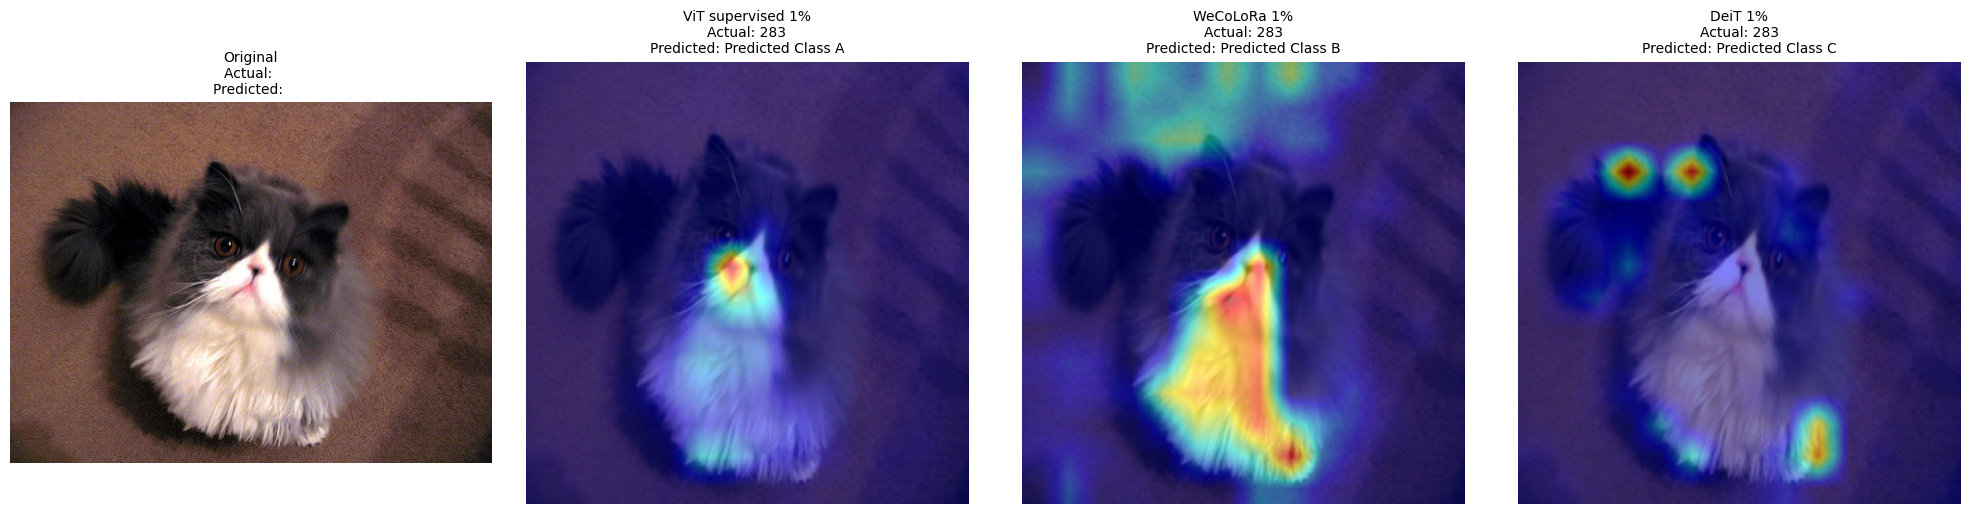

In [242]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

def plot_multiple_images(image_paths, model_names, actual_classes, predicted_classes):
    num_images = len(image_paths)

    # Create figure and axes
    fig, axs = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

    for i in range(num_images):
        # Load the current image
        img = Image.open(image_paths[i])

        # Plot the current image
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"{model_names[i]}\nActual: {actual_classes[i]}\nPredicted: {predicted_classes[i]}", fontsize=10)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    #plt.show()
    plt.savefig("/media/tonio/p2/ssl-medical-satellite/visuals_attention/attention-grad-rollout.pdf", format='pdf', bbox_inches="tight")

# Example usage with three images
image_paths = ["/media/tonio/p2/ssl-medical-satellite/n02123394_26.JPEG",
    "/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=283=persian_supervised_1_percent_2.png", 
               "/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=283=persian_supervised_1_percent_lora_2.png", 
               "/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=283=persian_deit_2.png"]
model_names = ["Original", "ViT supervised 1%", "WeCoLoRa 1%", "DeiT 1%"]

plot_multiple_images(image_paths, model_names, actual_classes, predicted_classes)

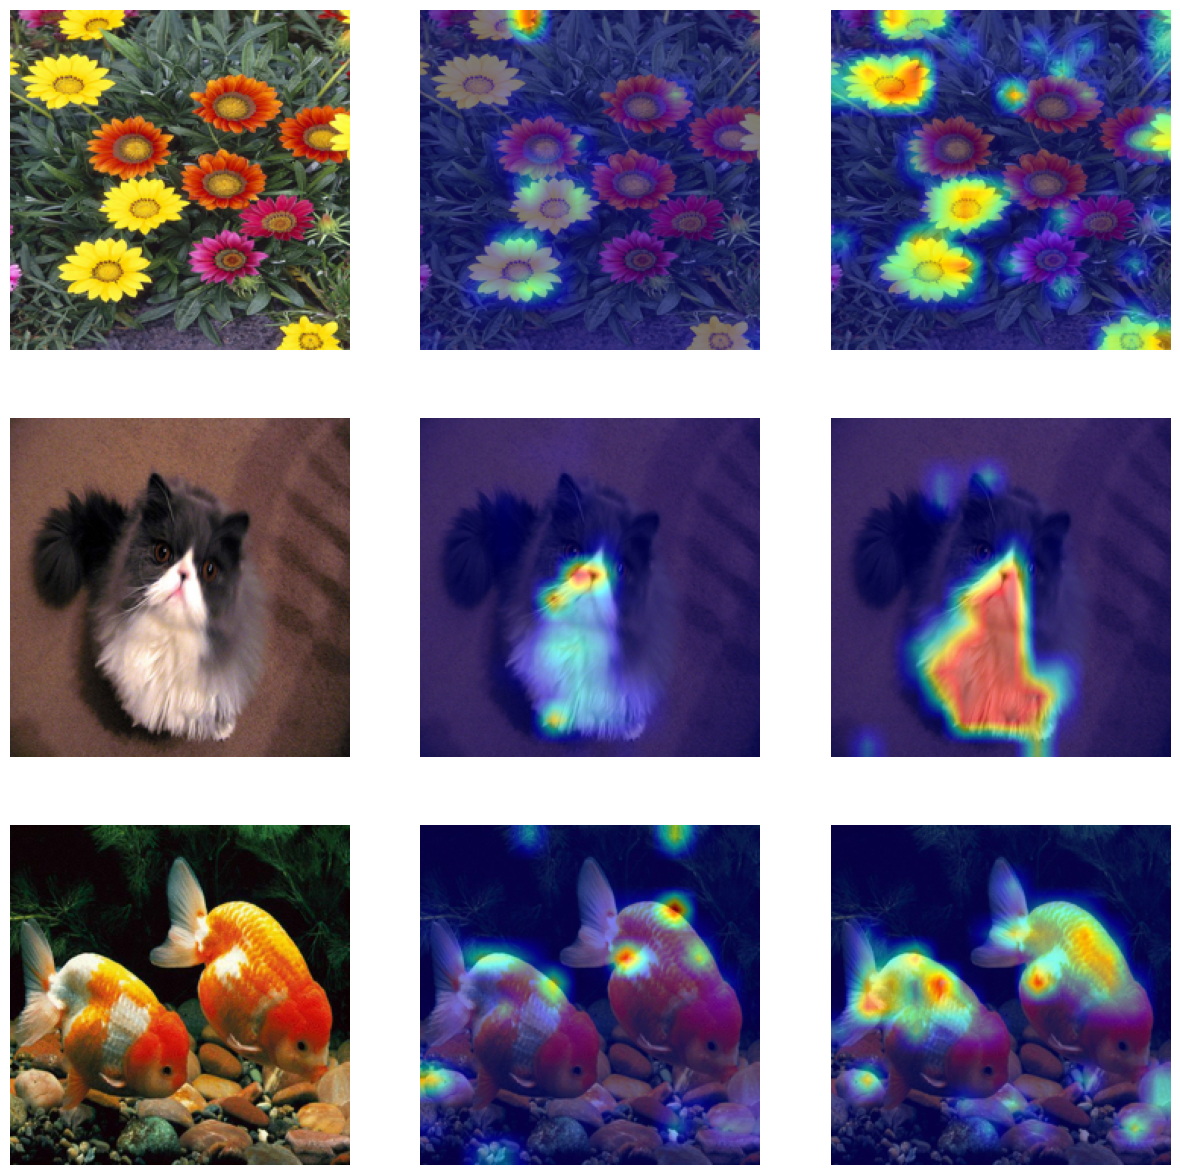

In [126]:
import matplotlib.pyplot as plt
from PIL import Image

# Example image paths (replace with your image paths)
group1_images = ['/media/tonio/p2/ssl-medical-satellite/visuals_attention/input_daisy.png', 
                 '/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=985=daisy_WeCo_simple.png', 
                 '/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=985=daisy_WeCoLoRa_simple.png']
group2_images = ['/media/tonio/p2/ssl-medical-satellite/visuals_attention/input_persian.png', 
                 '/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=283=persian_WeCo_simple.png', 
                 '/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=283=persian_WeCoLoRa_simple.png']
group3_images = ['/media/tonio/p2/ssl-medical-satellite/visuals_attention/input_goldfish.png', 
                 '/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=1=goldfish_WeCo_simple.png',
                 '/media/tonio/p2/ssl-medical-satellite/visuals_attention/mask=1=goldfish_WeCoLoRa_simple.png']

def plot_all_images(groups):
    plt.figure(figsize=(15, 15))

    for i, image_paths in enumerate(groups, 1):
        for j, path in enumerate(image_paths, 1):
            img = Image.open(path)
            plt.subplot(3, 3, (i-1)*3 + j)
            plt.imshow(img)
            plt.axis('off')
            
    plt.savefig("/media/tonio/p2/ssl-medical-satellite/visuals_attention/attention-grad-rollout.pdf", format='pdf', bbox_inches="tight")
    #plt.tight_layout()
    #plt.show()

# Plot all three groups of images in the same figure
plot_all_images([group1_images, group2_images, group3_images])